In [1]:
pip install segmentation-models-pytorch matplotlib torchvision ipywidgets onnx charset_normalizer

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
seed = 42
seed = seed % (2**64)  # Ensure seed fits in 64-bit integer

random.seed(seed)                 # Python random module
np.random.seed(seed & 0xFFFFFFFF)  # NumPy (32-bit seed)
torch.manual_seed(seed)           # PyTorch CPU
torch.cuda.manual_seed(seed)      # PyTorch CUDA (if available)
torch.cuda.manual_seed_all(seed)  # All GPUs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
class TubeSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)
        mask_name = os.path.splitext(image_name)[0] + "_mask.png"
        mask_path = os.path.join(self.mask_dir, mask_name)

        # Load images as PIL
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        # Transform mask to tensor
        mask = T.Resize((256, 256))(mask)
        mask = T.ToTensor()(mask)
        mask = (mask > 0.5).float()  # Convert to binary mask

        return image, mask

In [5]:
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [6]:
import torch
import torch.nn.functional as F

def dice_loss(preds, targets, smooth=1):
    # preds: raw logits from the model, shape [B, 1, H, W]
    # targets: ground truth masks, same shape

    preds = torch.sigmoid(preds)  # convert logits to probabilities
    preds = preds.view(-1)
    targets = targets.view(-1)

    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum()

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

In [7]:
import torch.nn as nn

bce_loss = nn.BCEWithLogitsLoss()

def bce_dice_loss(preds, targets):
    bce = bce_loss(preds, targets)
    d_loss = dice_loss(preds, targets)
    return bce + d_loss

In [8]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None,
)

In [9]:
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn

project_path = '/home/noob/koty/new_before_last/work/data/'

# Your full train dataset
full_dataset = TubeSegmentationDataset(project_path + "images-labelme", project_path + "masks-segmentation", transform=transform)

# Split into train and val (e.g., 80% train, 20% val)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # device = torch.device("cpu")
model.to(device)

# criterion = nn.BCEWithLogitsLoss()
criterion = bce_dice_loss

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Note: lr max is 1e-3 here
num_epochs = 22

from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=3,
)


In [11]:
import numpy as np

In [12]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_pixels = 0

    for batch_idx, (images, masks) in enumerate(train_loader):
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        
        # masks are already [B, 1, H, W] from the dataset
        # No need to unsqueeze

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        with torch.no_grad():
            preds = torch.sigmoid(outputs) > 0.5
            total_correct += (preds == masks).sum().item()
            total_pixels += torch.numel(masks)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / total_pixels

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_pixels = 0
    
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images = val_images.to(device, non_blocking=True)
            val_masks = val_masks.to(device, non_blocking=True)

            val_outputs = model(val_images)
            loss_val = criterion(val_outputs, val_masks)
            val_loss += loss_val.item()

            val_preds = torch.sigmoid(val_outputs) > 0.5
            val_correct += (val_preds == val_masks).sum().item()
            val_pixels += torch.numel(val_masks)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_pixels

    scheduler.step(avg_val_loss)

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f} | "
        f"LR: {optimizer.param_groups[0]['lr']:.6f}"
    )
    
    # Optional: Save best model
    if epoch == 0 or avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Best model saved with val_loss: {best_val_loss:.4f}")

print("Training completed!")

Epoch 1/22 | Train Loss: 1.5245 | Train Acc: 0.7129 | Val Loss: 8.6559 | Val Acc: 0.2432 | LR: 0.001000
Best model saved with val_loss: 8.6559
Epoch 2/22 | Train Loss: 1.2005 | Train Acc: 0.9876 | Val Loss: 1.4125 | Val Acc: 0.8019 | LR: 0.001000
Best model saved with val_loss: 1.4125
Epoch 3/22 | Train Loss: 1.0604 | Train Acc: 0.9964 | Val Loss: 1.0938 | Val Acc: 0.9750 | LR: 0.001000
Best model saved with val_loss: 1.0938
Epoch 4/22 | Train Loss: 0.9348 | Train Acc: 0.9976 | Val Loss: 0.8622 | Val Acc: 0.9967 | LR: 0.001000
Best model saved with val_loss: 0.8622
Epoch 5/22 | Train Loss: 0.8202 | Train Acc: 0.9982 | Val Loss: 0.7271 | Val Acc: 0.9981 | LR: 0.001000
Best model saved with val_loss: 0.7271
Epoch 6/22 | Train Loss: 0.7082 | Train Acc: 0.9987 | Val Loss: 0.6249 | Val Acc: 0.9985 | LR: 0.001000
Best model saved with val_loss: 0.6249
Epoch 7/22 | Train Loss: 0.6047 | Train Acc: 0.9987 | Val Loss: 0.5405 | Val Acc: 0.9992 | LR: 0.001000
Best model saved with val_loss: 0.5405

In [13]:
import torch.nn.functional as F
from torchvision.utils import save_image

model.eval()
with torch.no_grad():
    for i, (img, _) in enumerate(train_loader):
        img = img.to(device)
        pred = torch.sigmoid(model(img))
        pred_mask = (pred > 0.5).float()
        save_image(pred_mask, f"pred_mask_{i}.png")
        break


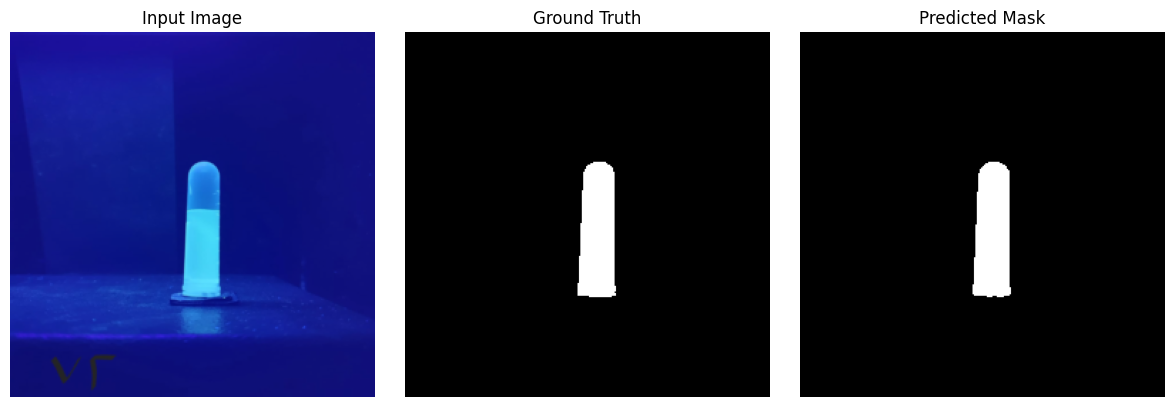

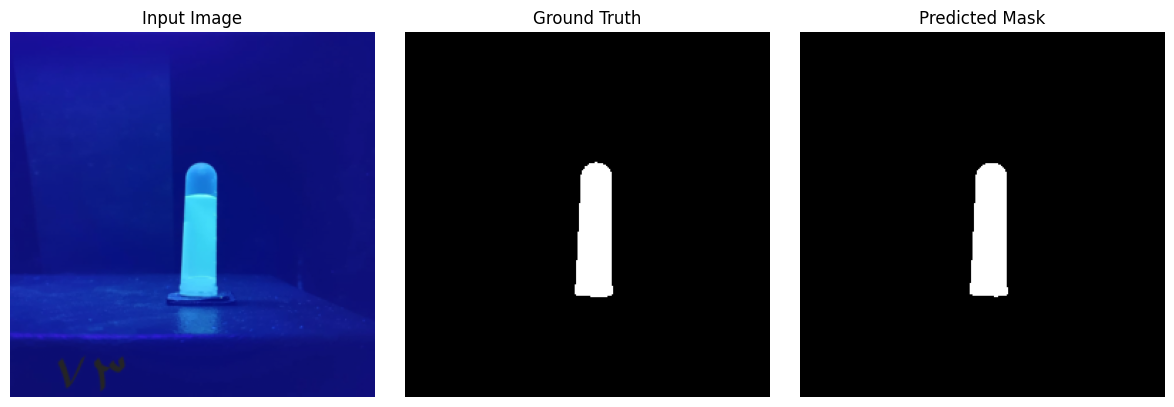

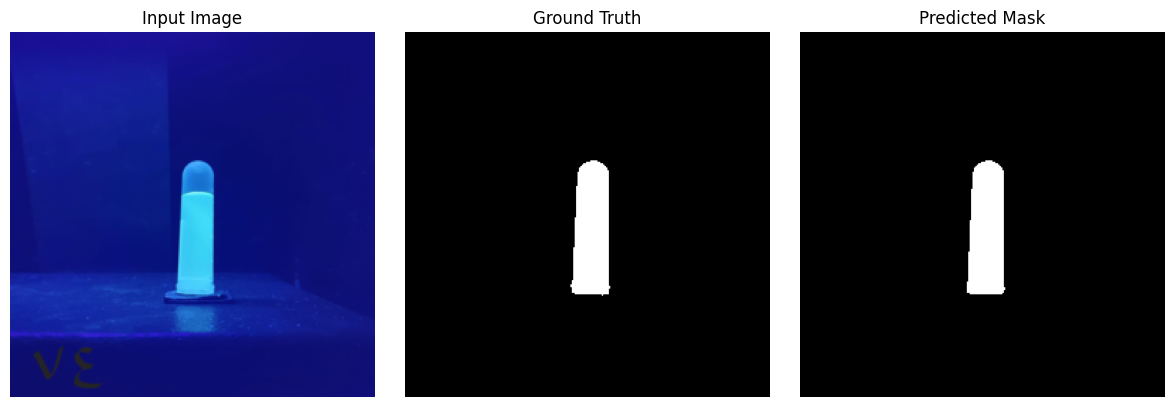

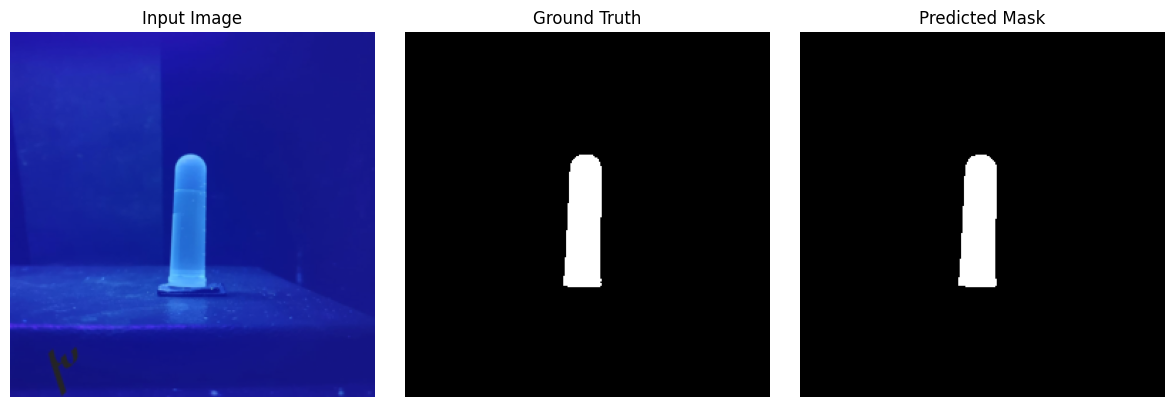

In [14]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

model.eval()
with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device)  # Remove .unsqueeze(1) since masks are already correct shape
        
        outputs = model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()
        
        images = images.cpu()
        masks = masks.cpu()
        preds = preds.cpu()
        
        for i in range(images.shape[0]):
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            
            # Denormalize image for display
            axs[0].imshow(images[i].permute(1, 2, 0) * 0.5 + 0.5)
            axs[0].set_title("Input Image")
            
            # Display masks - remove one dimension since masks are [B, 1, H, W]
            axs[1].imshow(masks[i].squeeze(0), cmap="gray")  # Remove channel dimension
            axs[1].set_title("Ground Truth")
            
            axs[2].imshow(preds[i].squeeze(0), cmap="gray")  # Remove channel dimension
            axs[2].set_title("Predicted Mask")
            
            for ax in axs:
                ax.axis("off")
            plt.tight_layout()
            plt.show()
        
        # Only show first batch to avoid too many plots
        break

In [15]:
import torch
import os
from datetime import datetime

# Create deployment directory
deploy_dir = "/home/noob/koty/new_before_last/work/deployment/Segmentation/"
os.makedirs(deploy_dir, exist_ok=True)

model.eval()  # Set to eval mode before saving

print("Saving model for deployment...")

# 1. Save just the state dict (recommended for same architecture)
state_dict_path = os.path.join(deploy_dir, "unet_resnet34_weights.pth")
torch.save(model.state_dict(), state_dict_path)
print(f"✅ State dict saved: {state_dict_path}")

# 2. Save complete model (includes architecture)
complete_model_path = os.path.join(deploy_dir, "unet_resnet34_complete.pth")
torch.save(model, complete_model_path)
print(f"✅ Complete model saved: {complete_model_path}")

# 3. Save model with metadata for better deployment
deployment_package = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'encoder_name': 'resnet34',
        'encoder_weights': 'imagenet',
        'in_channels': 3,
        'classes': 1,
        'activation': None
    },
    'preprocessing': {
        'input_size': (256, 256),
        'normalize_mean': [0.5, 0.5, 0.5],
        'normalize_std': [0.5, 0.5, 0.5]
    },
    'training_info': {
        'num_epochs': num_epochs,
        'optimizer': 'Adam',
        'learning_rate': 1e-3,
        'loss_function': 'BCE + Dice',
        'saved_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
}

package_path = os.path.join(deploy_dir, "deployment_package.pth")
torch.save(deployment_package, package_path)
print(f"✅ Deployment package saved: {package_path}")

# 4. Export to ONNX for cross-platform deployment (optional)
try:
    # Create dummy input for ONNX export
    dummy_input = torch.randn(1, 3, 256, 256).to(device)
    onnx_path = os.path.join(deploy_dir, "unet_resnet34.onnx")
    
    torch.onnx.export(
        model,
        dummy_input,
        onnx_path,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    print(f"✅ ONNX model saved: {onnx_path}")
except Exception as e:
    print(f"⚠️  ONNX export failed: {e}")

# 5. Create deployment script template with exact shape cropping
deployment_script = '''
import torch
import segmentation_models_pytorch as smp
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import os

class TubeSegmentationModel:
    def __init__(self, model_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = torch.device(device)
        
        # Load deployment package
        package = torch.load(model_path, map_location=self.device)
        
        # Recreate model
        self.model = smp.Unet(
            encoder_name=package['model_config']['encoder_name'],
            encoder_weights=None,  # Don't load pretrained for deployment
            in_channels=package['model_config']['in_channels'],
            classes=package['model_config']['classes'],
            activation=package['model_config']['activation']
        )
        
        # Load trained weights
        self.model.load_state_dict(package['model_state_dict'])
        self.model.to(self.device)
        self.model.eval()
        
        # Setup preprocessing
        self.preprocess = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=package['preprocessing']['normalize_mean'],
                std=package['preprocessing']['normalize_std']
            )
        ])
        
        print(f"Model loaded successfully on {self.device}")
        print(f"Training info: {package['training_info']}")
    
    def predict_and_crop_exact_shape(self, image_path, output_dir=None, threshold=0.5, 
                                   padding=10, transparent_background=True, 
                                   edge_smoothing=True, feather_edges=2):
        """
        Predict mask and create exact shape cropped image
        
        Args:
            image_path: Path to input image
            output_dir: Directory to save outputs (if None, saves in same dir as input)
            threshold: Confidence threshold for binary mask
            padding: Extra pixels around the detected object
            transparent_background: If True, creates PNG with transparent background
            edge_smoothing: Apply Gaussian blur to smooth edges
            feather_edges: Pixels to feather the edges (0 = no feathering)
        
        Returns:
            dict with paths to saved files and metadata
        """
        # Load and preprocess image
        original_image = Image.open(image_path).convert('RGB')
        original_size = original_image.size
        
        input_tensor = self.preprocess(original_image).unsqueeze(0).to(self.device)
        
        # Predict
        with torch.no_grad():
            output = self.model(input_tensor)
            pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()
        
        # Resize mask back to original size using OpenCV for better quality
        mask_resized = cv2.resize(pred_mask, original_size, interpolation=cv2.INTER_LINEAR)
        
        # Apply edge smoothing if requested
        if edge_smoothing:
            mask_smooth = cv2.GaussianBlur(mask_resized, (5, 5), 1.0)
            binary_mask = (mask_smooth > threshold).astype(np.float32)
            
            # Apply feathering for smooth edges
            if feather_edges > 0:
                binary_uint8 = (binary_mask * 255).astype(np.uint8)
                dist_transform = cv2.distanceTransform(binary_uint8, cv2.DIST_L2, 5)
                feather_mask = np.minimum(dist_transform / feather_edges, 1.0)
                feather_mask = np.where(binary_mask > 0, feather_mask, 0)
                alpha_mask = (feather_mask * 255).astype(np.uint8)
            else:
                alpha_mask = (binary_mask * 255).astype(np.uint8)
        else:
            binary_mask = (mask_resized > threshold).astype(np.float32)
            alpha_mask = (binary_mask * 255).astype(np.uint8)
        
        # Setup output paths
        if output_dir is None:
            output_dir = os.path.dirname(image_path)
        os.makedirs(output_dir, exist_ok=True)
        
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        mask_path = os.path.join(output_dir, f"{base_name}_mask.png")
        
        # Save mask
        mask_pil = Image.fromarray(alpha_mask, 'L')
        mask_pil.save(mask_path)
        
        # Check if object detected
        if alpha_mask.max() == 0:
            return {
                'success': False,
                'mask_path': mask_path,
                'cropped_path': None,
                'error': 'No object detected in image',
                'confidence_score': float(pred_mask.max()),
                'mask_area_ratio': 0.0
            }
        
        # Find bounding box of the mask
        coords = np.where(alpha_mask > 10)  # Small threshold to include feathered edges
        top, left = coords[0].min(), coords[1].min()
        bottom, right = coords[0].max(), coords[1].max()
        
        # Add padding to bounding box
        left = max(0, left - padding)
        top = max(0, top - padding)
        right = min(original_size[0], right + padding)
        bottom = min(original_size[1], bottom + padding)
        
        # Crop the original image and mask to bounding box
        original_array = np.array(original_image)
        cropped_image = original_array[top:bottom+1, left:right+1]
        cropped_alpha = alpha_mask[top:bottom+1, left:right+1]
        
        # Create different output versions
        results = {}
        
        if transparent_background:
            # Create RGBA image with transparent background
            cropped_path = os.path.join(output_dir, f"{base_name}_exact_shape.png")
            
            rgba_image = np.zeros((cropped_image.shape[0], cropped_image.shape[1], 4), dtype=np.uint8)
            rgba_image[:, :, :3] = cropped_image  # RGB channels
            rgba_image[:, :, 3] = cropped_alpha   # Alpha channel from mask
            
            # Save as PNG with transparency
            rgba_pil = Image.fromarray(rgba_image, 'RGBA')
            rgba_pil.save(cropped_path)
            results['cropped_path'] = cropped_path
            
        else:
            # Create image with white background where mask is 0
            cropped_path = os.path.join(output_dir, f"{base_name}_exact_shape_white_bg.png")
            
            mask_3d = np.stack([cropped_alpha, cropped_alpha, cropped_alpha], axis=2) / 255.0
            white_background = np.ones_like(cropped_image) * 255
            final_image = (cropped_image * mask_3d + white_background * (1 - mask_3d)).astype(np.uint8)
            
            final_pil = Image.fromarray(final_image)
            final_pil.save(cropped_path)
            results['cropped_path'] = cropped_path
        
        # Always create a black background version for comparison
        black_bg_path = os.path.join(output_dir, f"{base_name}_exact_shape_black_bg.png")
        mask_3d = np.stack([cropped_alpha, cropped_alpha, cropped_alpha], axis=2) / 255.0
        black_background = np.zeros_like(cropped_image)
        black_bg_image = (cropped_image * mask_3d + black_background * (1 - mask_3d)).astype(np.uint8)
        black_bg_pil = Image.fromarray(black_bg_image)
        black_bg_pil.save(black_bg_path)
        results['black_bg_path'] = black_bg_path
        
        result = {
            'success': True,
            'mask_path': mask_path,
            'bbox': (left, top, right, bottom),
            'cropped_size': (right - left, bottom - top),
            'confidence_score': float(pred_mask.max()),
            'mask_area_ratio': float(binary_mask.sum() / binary_mask.size),
            'exact_shape': True,
            'transparent_background': transparent_background,
            'edge_smoothing': edge_smoothing,
            'feather_edges': feather_edges
        }
        result.update(results)
        
        return result
    
    def batch_process(self, input_dir, output_dir, threshold=0.5, padding=10, 
                     transparent_background=True, edge_smoothing=True, feather_edges=2):
        """
        Process multiple images in a directory with exact shape cropping
        """
        os.makedirs(output_dir, exist_ok=True)
        
        image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
        image_files = [f for f in os.listdir(input_dir) 
                      if f.lower().endswith(image_extensions)]
        
        results = []
        print(f"Processing {len(image_files)} images with exact shape cropping...")
        
        for filename in image_files:
            image_path = os.path.join(input_dir, filename)
            try:
                result = self.predict_and_crop_exact_shape(
                    image_path, output_dir, threshold, padding,
                    transparent_background, edge_smoothing, feather_edges
                )
                result['filename'] = filename
                results.append(result)
                
                if result['success']:
                    print(f"✅ {filename} - Exact shape extracted: {result['cropped_size']}")
                else:
                    print(f"❌ {filename} - {result['error']}")
                    
            except Exception as e:
                print(f"❌ {filename} - Error: {str(e)}")
                results.append({
                    'filename': filename,
                    'success': False,
                    'error': str(e)
                })
        
        # Save summary
        successful = sum(1 for r in results if r.get('success', False))
        summary_path = os.path.join(output_dir, 'exact_shape_processing_summary.txt')
        with open(summary_path, 'w') as f:
            f.write(f"Exact Shape Cropping Summary\\n")
            f.write(f"============================\\n")
            f.write(f"Total images: {len(image_files)}\\n")
            f.write(f"Successfully processed: {successful}\\n")
            f.write(f"Failed: {len(image_files) - successful}\\n")
            f.write(f"Success rate: {successful/len(image_files)*100:.1f}%\\n")
            f.write(f"Settings: threshold={threshold}, padding={padding}\\n")
            f.write(f"Edge smoothing: {edge_smoothing}, Feather edges: {feather_edges}\\n\\n")
            
            for result in results:
                if result.get('success'):
                    f.write(f"✅ {result['filename']} - Size: {result['cropped_size']}, "
                           f"Confidence: {result['confidence_score']:.3f}, "
                           f"Mask ratio: {result['mask_area_ratio']:.3f}\\n")
                else:
                    f.write(f"❌ {result['filename']} - {result.get('error', 'Unknown error')}\\n")
        
        print(f"\\nExact shape processing complete! Summary saved to: {summary_path}")
        return results

# Usage examples:
# 
# # Single image processing with exact shape (transparent background)
# model = TubeSegmentationModel('deployment_package.pth')
# result = model.predict_and_crop_exact_shape('input_image.jpg', 'output_folder/', 
#                                           threshold=0.5, padding=5, 
#                                           transparent_background=True,
#                                           edge_smoothing=True, feather_edges=3)
# print(f"Exact shape cropped image saved to: {result['cropped_path']}")
#
# # Batch processing with exact shape cropping
# model = TubeSegmentationModel('deployment_package.pth')
# results = model.batch_process('input_folder/', 'output_folder/', 
#                              threshold=0.5, padding=10,
#                              transparent_background=True,
#                              edge_smoothing=True, feather_edges=2)
'''

script_path = os.path.join(deploy_dir, "deployment_script.py")
with open(script_path, 'w') as f:
    f.write(deployment_script)
print(f"✅ Deployment script created: {script_path}")

# 6. Create requirements.txt for deployment environment
requirements = '''torch>=1.9.0
torchvision>=0.10.0
segmentation-models-pytorch>=0.3.0
Pillow>=8.0.0
numpy>=1.19.0
opencv-python>=4.5.0
'''

req_path = os.path.join(deploy_dir, "requirements.txt")
with open(req_path, 'w') as f:
    f.write(requirements)
print(f"✅ Requirements file created: {req_path}")

print(f"\n🎉 Enhanced Deployment package ready in '{deploy_dir}' folder!")
print("\nFiles created:")
print("- unet_resnet34_weights.pth (state dict only)")
print("- unet_resnet34_complete.pth (complete model)")
print("- deployment_package.pth (model + metadata)")
print("- unet_resnet34.onnx (ONNX format, if successful)")
print("- deployment_script.py (enhanced with exact shape cropping)")
print("- requirements.txt (dependencies including OpenCV)")

print("\n🚀 Enhanced Usage Examples:")
print("# Single image with exact shape cropping:")
print("model = TubeSegmentationModel('deployment_package.pth')")
print("result = model.predict_and_crop_exact_shape('image.jpg', 'output/',")
print("                                          threshold=0.5, padding=5,")
print("                                          transparent_background=True,")
print("                                          edge_smoothing=True, feather_edges=3)")
print("print(f'Exact shape saved: {result[\"cropped_path\"]}')")
print()
print("# Batch processing with exact shape:")
print("results = model.batch_process('input_folder/', 'output_folder/',")
print("                             threshold=0.5, transparent_background=True,")
print("                             edge_smoothing=True, feather_edges=2)")
print()
print("🎯 Key Features:")
print("- Exact pixel-perfect shape cutting (no rectangular boxes)")
print("- Transparent PNG backgrounds")
print("- Edge smoothing and feathering for professional results") 
print("- Multiple output formats (transparent, white bg, black bg)")
print("- Advanced mask processing with OpenCV")
print("\nFor deployment, use 'deployment_package.pth' with 'deployment_script.py'")

Saving model for deployment...
✅ State dict saved: /home/noob/koty/new_before_last/work/deployment/Segmentation/unet_resnet34_weights.pth
✅ Complete model saved: /home/noob/koty/new_before_last/work/deployment/Segmentation/unet_resnet34_complete.pth
✅ Deployment package saved: /home/noob/koty/new_before_last/work/deployment/Segmentation/deployment_package.pth
✅ ONNX model saved: /home/noob/koty/new_before_last/work/deployment/Segmentation/unet_resnet34.onnx
✅ Deployment script created: /home/noob/koty/new_before_last/work/deployment/Segmentation/deployment_script.py
✅ Requirements file created: /home/noob/koty/new_before_last/work/deployment/Segmentation/requirements.txt

🎉 Enhanced Deployment package ready in '/home/noob/koty/new_before_last/work/deployment/Segmentation/' folder!

Files created:
- unet_resnet34_weights.pth (state dict only)
- unet_resnet34_complete.pth (complete model)
- deployment_package.pth (model + metadata)
- unet_resnet34.onnx (ONNX format, if successful)
- depl